In [43]:
from Functions.data_analysis import *
from Functions.database import getTransaction, getAccount
from Functions.classes import *
from Functions.dicts import *

import numpy as np
import pandas as pd

from scipy.stats import linregress
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')


In [44]:
class enrichedData:
    def __init__(self, old_data: pd.DataFrame, data: pd.DataFrame, figsize: tuple[int, int] = (10, 5)) -> None:
        self.old_data = old_data
        self.data = data
        self.figsize = figsize
        
    def plotAll(self, RANGE1: str, RANGE2: str, displacement: tuple[int, ...]):
        _, ax = plt.subplots(figsize=self.figsize)

        if RANGE1 != "YEAR":
            last_data = self.data['Features', RANGE2].iloc[-1] - displacement
            curData = self.data[self.data['Features', RANGE2] == last_data]
            curData = curData.groupby(self.data['Features'][RANGE1]).sum()

            ax.text(0.5, 1.01, f"{RANGE2.title()} {last_data}", ha='center', va='center', transform=ax.transAxes, fontsize=15)
        else:
            curData = self.data.groupby(self.data['Features']['YEAR']).sum()
            last_data = curData.index[-1]

            ax.text(0.5, 1.01, f"All Year", ha='center', va='center', transform=ax.transAxes, fontsize=15)


        plt.xlabel(RANGE1.title())
        plt.ylabel("Rp.")
        plt.title("Complete Plot", pad=20)

        plt.xticks([int(year) for year in curData.index])
    
        curData['Expenses']['TOTAL'].cumsum().plot(ax=ax, label='Cumulative Expenses', alpha=0.6)
        curData['Revenue']['TOTAL'].cumsum().plot(ax=ax, label='Cumulative Revenue', alpha=0.6)
        curData['TOTAL'].cumsum().plot(ax=ax, label='Budget', alpha=0.6)
    
        plt.legend()
        plt.show()

        exported_data = []
        for year in curData.index:
            exported_data.append([
                curData[('Expenses', 'TOTAL')].loc[year],
                curData[('Revenue', 'TOTAL')].loc[year],
                curData[('Revenue', 'TOTAL')].loc[year] - curData[('Expenses', 'TOTAL')].loc[year]
            ])

        return exported_data, curData.index[0], len(curData.index)

    def plotCategory(self):
        _, ax = plt.subplots(figsize=self.figsize)

        all_types = [0, 1, 2, 3, 4, 5, 10, 11, 12, 13]

        byType = self.old_data.groupby('TYPE')['VALUE'].sum().reset_index()
        byType = byType.set_index('TYPE').reindex(all_types, fill_value=0).reset_index()
        byType['TYPE_LABEL'] = byType['TYPE'].map(typeMapping)
        byType = byType.sort_values("VALUE", ascending=False)

        colors = ["red" if type_val < 10 else "green" for type_val in byType['TYPE']]
        plt.bar(byType['TYPE_LABEL'], byType['VALUE'], color=colors)

        plt.xlabel('Type')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Rp.')
        plt.title('Expenses by Type')
        ax.text(0.5, 1.01, f"All Year", ha='center', va='center', transform=ax.transAxes, fontsize=15)
        
        plt.show()


        exported_data = []
        for i in byType.index:
            exported_data.append([
                byType['TYPE_LABEL'][i], 
                byType['VALUE'].loc[i]
            ])

        return exported_data

    def getLinReg(self):
        data = self.data

        totalYear = self.data['Features'].iloc[-1]['YEAR'] - self.data['Features'].iloc[0]['YEAR'] + 1

        linreg = []
        for y in ['Expenses', 'Revenue']:
            curtype = []
            for x in ['DAY', 'WEEK', 'MONTH', 'QUARTER', 'YEAR']:
                cur_data = data.copy()
                cur_data[x] = cur_data['Features'][x]
                cur_data = cur_data.groupby(x, as_index=False)[y].sum()
                cur_data['Cumulative'] = cur_data[y]['TOTAL'].cumsum()

                slope, intercept, r_value, p_value, std_err = linregress(cur_data[x], cur_data['Cumulative'])

                slope /= totalYear

                curtype.append(slope)
            
            linreg.append(curtype)

        curtype = []
        for i in range(5):
            curtype.append(linreg[1][i] - linreg[0][i])
        
        linreg.append(curtype)

        return linreg
    
    def plotTimeCycle(self, x: int):
        if x < 0 or x > 4:
            return

        _, ax = plt.subplots(figsize=self.figsize)

        time_cycle = ["DoW", "WoM", "MONTH", "QUARTER", "YEAR"][x]
        time_dict = [dayMapping, weekMapping, monthMapping, quarterMapping, None][x]
        title = ["Day", "Week", "Month", "Quarter", "Year"][x]

        cur_data = self.data.copy()
        cur_data[time_cycle] = cur_data['Features'][time_cycle]

        if time_cycle == "WoM":
            cur_data[time_cycle] = cur_data[time_cycle].replace(6, 5)
        
        # Your code block to process cur_data
        cur_data['ET'] = cur_data[('Expenses', 'TOTAL')]
        cur_data['RT'] = cur_data[('Revenue', 'TOTAL')]
        cur_data = cur_data.sort_index(axis=1)
        cur_data = cur_data.drop(columns=['Features'])

        cur_data = cur_data.groupby(time_cycle, as_index=False).sum()

        # Continue with the rest of the logic
        if ('Expenses', '5') in cur_data.columns:
            cur_data.loc[:, ('Expenses', 'TOTAL')] = cur_data[('Expenses', 'TOTAL')] - cur_data[('Expenses', '5')]

        indices = np.arange(len(cur_data))
        bar_width = 0.35

        plt.bar(indices, cur_data[('Expenses', 'TOTAL')], width=bar_width, label='Expenses')
        plt.bar(indices + bar_width, cur_data[('Revenue', 'TOTAL')], width=bar_width, label='Revenue')

        if time_cycle != "YEAR":
            cur_data['LABEL'] = cur_data[time_cycle].map(time_dict).fillna("Unknown")
        else:
            cur_data['LABEL'] = cur_data[time_cycle].astype(str)

        plt.xlabel(title)
        if time_cycle == "MONTH":
            plt.xticks(indices + bar_width / 2, cur_data['LABEL'], rotation=45, ha='right')
        else:
            plt.xticks(indices + bar_width / 2, cur_data['LABEL'])
        plt.ylabel('Rp.')
        plt.title(f'{title} Distribution')
        plt.legend()

        exported_data = []
        for i in cur_data.index:
            exported_data.append([
                cur_data['ET'].loc[i],
                cur_data['RT'].loc[i]
            ])

        if time_cycle == "YEAR":
            start = cur_data['YEAR'].loc[0]
        else:
            start = None

        return title, exported_data, start



In [45]:
def enrichData(df: pd.DataFrame) -> enrichedData:
    old_data = df.copy()
    
    def WoM(dt):
      """ Returns the week of the month for the specified date. """
      first_day = dt.replace(day=1)
      dom = dt.day
      adjusted_dom = dom + first_day.weekday()
      return int(np.ceil(adjusted_dom / 7.0))
    
    df['CREATED_AT'] = pd.to_datetime(df['CREATED_AT'])
    df = df.drop(columns=['UPDATED_AT', 'TRANSACTION_ID', 'ITEM', 'USERNAME']).set_index('CREATED_AT').sort_index()

    # Create expenses DataFrame
    expenses_list = [
      df[(df['CATEGORY'] == 0) & (df['TYPE'] == i)]
      .drop(columns=['CATEGORY', 'TYPE'])
      .resample('D')
      .sum()
      .rename(columns={'VALUE': f'{i}'})
      for i in df[df['CATEGORY'] == 0]['TYPE'].unique()
    ]

    expenses_list = [x for x in expenses_list if not x.empty]  # Ensure non-empty DataFrames
    expenses = pd.concat(expenses_list, axis=1) if expenses_list else pd.DataFrame()

    # Create revenue DataFrame
    revenue_list = [
      df[(df['CATEGORY'] == 1) & (df['TYPE'] == i)]
      .drop(columns=['CATEGORY', 'TYPE'])
      .resample('D')
      .sum()
      .rename(columns={'VALUE': f'{i}'})
      for i in df[df['CATEGORY'] == 1]['TYPE'].unique()
    ]
    revenue_list = [x for x in revenue_list if not x.empty]  # Ensure non-empty DataFrames
    revenue = pd.concat(revenue_list, axis=1) if revenue_list else pd.DataFrame()

    # Reindex and set up columns
    if not expenses.empty:
      expenses = expenses.reindex(sorted(expenses.columns, key=lambda x: int(x)), axis=1)
      expenses.columns = pd.MultiIndex.from_product([['Expenses'], expenses.columns])
      expenses[('Expenses', 'TOTAL')] = expenses.sum(axis=1)
    
    if not revenue.empty:
      revenue = revenue.reindex(sorted(revenue.columns, key=lambda x: int(x)), axis=1)
      revenue.columns = pd.MultiIndex.from_product([['Revenue'], revenue.columns])
      revenue[('Revenue', 'TOTAL')] = revenue.sum(axis=1)
    else:
      # If no revenue data, create the (Revenue, TOTAL) column with 0s
      revenue = pd.DataFrame(index=expenses.index)  # Ensure the same index as expenses
      revenue[('Revenue', 'TOTAL')] = 0

    # Combine expenses and revenue
    features = pd.DataFrame(index=expenses.index.union(revenue.index))
    datetime_index = pd.DatetimeIndex(features.index)

    features[("Features", "DoW")] = datetime_index.dayofweek
    features[("Features", "DoM")] = datetime_index.day
    features[("Features", "WoM")] = datetime_index.map(WoM)
    features[("Features", "DAY")] = datetime_index.dayofyear
    features[("Features", "WEEK")] = datetime_index.isocalendar().week
    features[("Features", "QUARTER")] = datetime_index.quarter
    features[("Features", "MONTH")] = datetime_index.month
    features[("Features", "YEAR")] = datetime_index.year

    # Combine all data
    DATA = pd.concat([expenses, revenue, features], axis=1).fillna(0)
    
    DATA.index.name = "DATE"
    DATA['TOTAL'] = DATA['Revenue', 'TOTAL'] - DATA['Expenses', 'TOTAL']

    return enrichedData(old_data, DATA)


In [46]:
myAcc = getAccount("user1")
myAcc.summary()

df = getTransaction(myAcc)

       Username: user1
       Password: 1f2d83e0eb5f88fa423249eb9f32de111e5b9dad9de98352a57070c10ca96f80
   Date Created: 2024-09-06 09:30:42
   Date Updated: 2024-09-06 09:30:42
        Balance: 0


In [47]:
myData = enrichData(df)

In [48]:
myData.data

Expenses                                      Revenue            \
                  0      1         2    3    5     TOTAL      10   11   12   
DATE                                                                         
2022-08-01    43000  20000       0.0  0.0  0.0   63000.0     0.0  0.0  0.0   
2022-08-02    55000  25000  150000.0  0.0  0.0  230000.0     0.0  0.0  0.0   
2022-08-03    70000  50000       0.0  0.0  0.0  120000.0     0.0  0.0  0.0   
2022-08-04    43000  40000       0.0  0.0  0.0   83000.0     0.0  0.0  0.0   
2022-08-05    68000      0       0.0  0.0  0.0   68000.0     0.0  0.0  0.0   
...             ...    ...       ...  ...  ...       ...     ...  ...  ...   
2024-09-08    36000  50000       0.0  0.0  0.0   86000.0     0.0  0.0  0.0   
2024-09-09    57000  50000       0.0  0.0  0.0  107000.0     0.0  0.0  0.0   
2024-09-10    50000      0       0.0  0.0  0.0   50000.0     0.0  0.0  0.0   
2024-09-11    23000      0       0.0  0.0  0.0   23000.0     0.0  0.0  0.0   
2024-09-12    30000  20000       0.0  0.0  0.0   50000.0     0.0  0.0  0.0   

                      Features                                           TOTAL  
             13 TOTAL      DoW DoM WoM  DAY WEEK QUARTER MONTH  YEAR            
DATE                                                                            
2022-08-01  0.0   0.0        0   1   1  213   31       3     8  2022  -63000.0  
2022-08-02  0.0   0.0        1   2   1  214   31       3     8  2022 -230000.0  
2022-08-03  0.0   0.0        2   3   1  215   31       3     8  2022 -120000.0  
2022-08-04  0.0   0.0        3   4   1  216   31       3     8  2022  -83000.0  
2022-08-05  0.0   0.0        4   5   1  217   31       3     8  2022  -68000.0  
...         ...   ...      ...  ..  ..  ...  ...     ...   ...   ...       ...  
2024-09-08  0.0   0.0        6   8   2  252   36       3     9  2024  -86000.0  
2024-09-09  0.0   0.0        0   9   3  253   37       3     9  2024 -107000.0  
2024-09-10  0.0   0.0        1  10   3  254   37       3     9  2024  -50000.0  
2024-09-11  0.0   0.0        2  11   3  255   37       3     9  2024  -23000.0  
2024-09-12  0.0   0.0        3  12   3  256   37       3     9  2024  -50000.0  

[774 rows x 20 columns]

('Month',
 [[4418000.0, 14000000.0],
  [54267000.0, 15000000.0],
  [4873000.0, 5000000.0],
  [5201000.0, 19000000.0],
  [4730000.0, 10000000.0],
  [3991000.0, 5000000.0],
  [4379000.0, 30000000.0],
  [6228000.0, 11000000.0],
  [4869000.0, 10000000.0],
  [4097000.0, 33000000.0],
  [3802000.0, 23000000.0],
  [54460000.0, 16000000.0]],
 None)

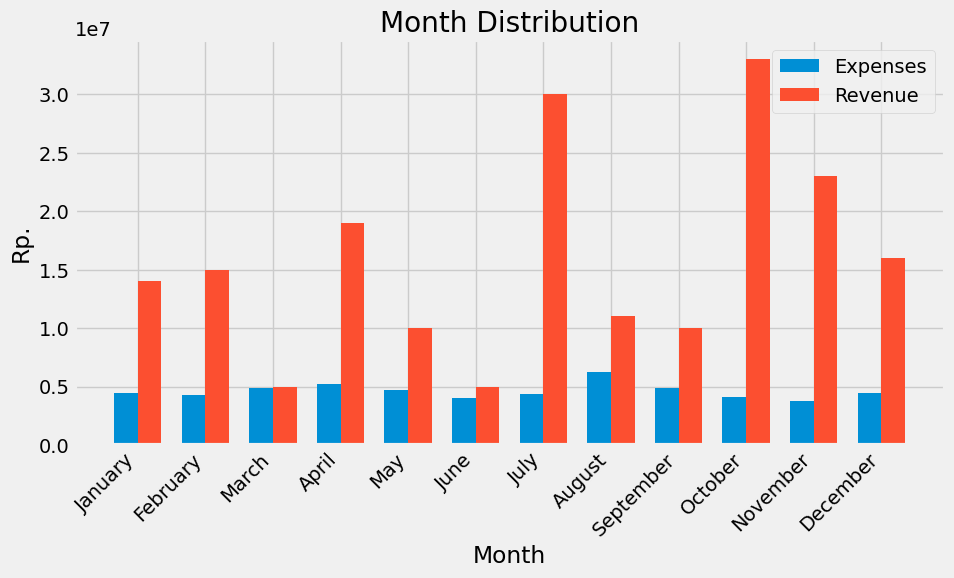

In [49]:
myData.plotTimeCycle(2)

In [61]:
(myData.data.index[-1].year - myData.data.index[0].year) > 0

True